In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv


In [5]:
# ============================================================
# Santander Customer Transaction Prediction
# Unsupervised approach (Isolation Forest) + EDA + Model analysis
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

RANDOM_STATE = 42

# ------------------------------------------------------------
# 1. Load data
# ------------------------------------------------------------
PATH = "../input/santander-customer-transaction-prediction"

train = pd.read_csv(os.path.join(PATH, "train.csv"))
test  = pd.read_csv(os.path.join(PATH, "test.csv"))

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (200000, 202)
Test shape: (200000, 201)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104



Columns:
Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7'],
      dtype='object')  ...

Target counts:
target
0    179902
1     20098
Name: count, dtype: int64

Target ratio (positive rate): 0.10049


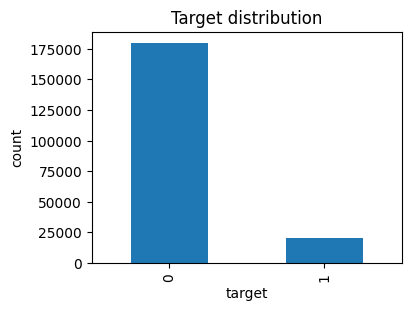


Missing values in train: 0
Missing values in test: 0

Feature count: 200

Train feature summary:


,count,mean,std,min,25%,50%,75%,max
var_0,200000.0,10.679914,3.040051,0.4084,8.453850,10.52475,12.758200,20.3150
var_1,200000.0,-1.627622,4.050044,-15.0434,-4.740025,-1.60805,1.358625,10.3768
var_2,200000.0,10.715192,2.640894,2.1171,8.722475,10.58000,12.516700,19.3530
var_3,200000.0,6.796529,2.043319,-0.0402,5.254075,6.82500,8.324100,13.1883
var_4,200000.0,11.078333,1.623150,5.0748,9.883175,11.10825,12.261125,16.6714


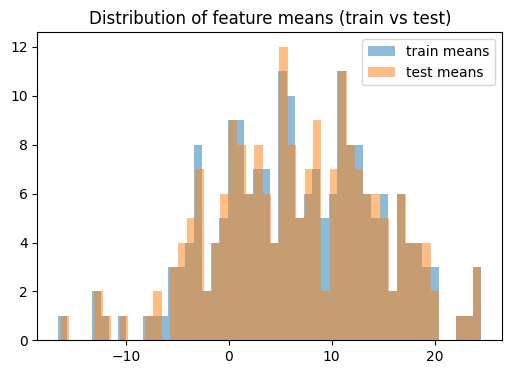

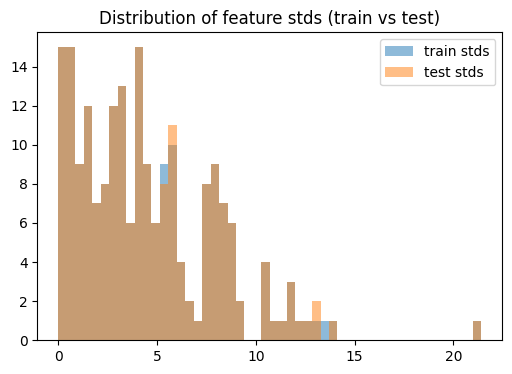

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


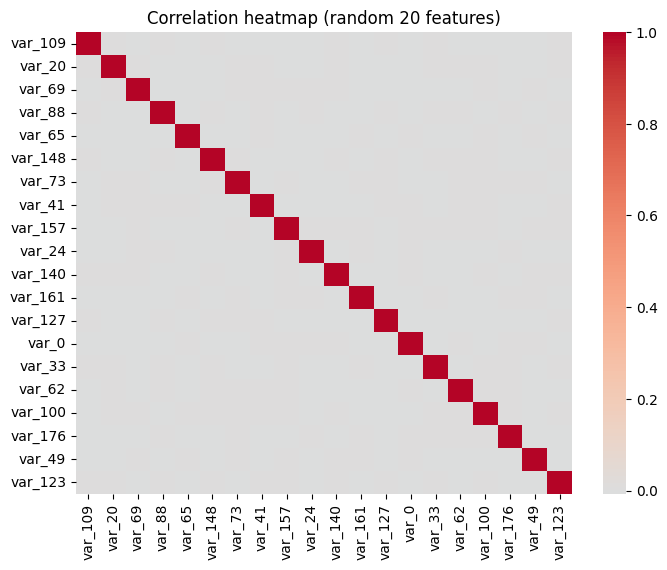

In [6]:
# ------------------------------------------------------------
# 2. Basic EDA
# ------------------------------------------------------------

# Column overview
print("\nColumns:")
print(train.columns[:10], " ...")

# Target distribution (class imbalance)
target_counts = train["target"].value_counts().sort_index()
print("\nTarget counts:")
print(target_counts)
print("\nTarget ratio (positive rate):", target_counts[1] / target_counts.sum())

plt.figure(figsize=(4,3))
target_counts.plot(kind="bar")
plt.title("Target distribution")
plt.xlabel("target")
plt.ylabel("count")
plt.show()

# Check missing values
missing_train = train.isnull().sum().sum()
missing_test  = test.isnull().sum().sum()
print("\nMissing values in train:", missing_train)
print("Missing values in test:", missing_test)

# Basic statistics of features
feature_cols = [c for c in train.columns if c not in ["ID_code", "target"]]
print("\nFeature count:", len(feature_cols))

train_feats = train[feature_cols]
test_feats  = test[feature_cols]

print("\nTrain feature summary:")
display(train_feats.describe().T.head())

# Compare distribution of means and stds between train and test
train_means = train_feats.mean()
test_means  = test_feats.mean()
train_stds  = train_feats.std()
test_stds   = test_feats.std()

plt.figure(figsize=(6,4))
plt.hist(train_means, bins=50, alpha=0.5, label="train means")
plt.hist(test_means,  bins=50, alpha=0.5, label="test means")
plt.title("Distribution of feature means (train vs test)")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(train_stds, bins=50, alpha=0.5, label="train stds")
plt.hist(test_stds,  bins=50, alpha=0.5, label="test stds")
plt.title("Distribution of feature stds (train vs test)")
plt.legend()
plt.show()

# Correlation of a random subset of features
sample_feats = np.random.choice(feature_cols, size=20, replace=False)
corr_sample = train[sample_feats].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_sample, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (random 20 features)")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


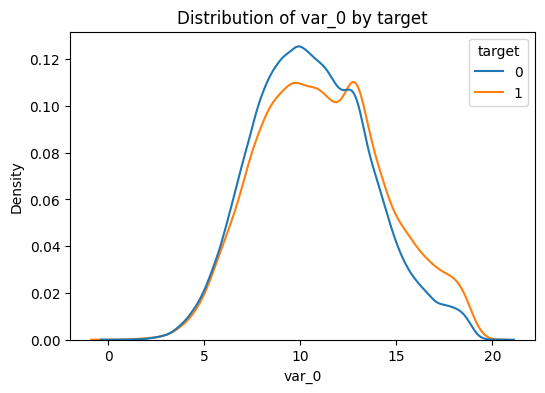

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


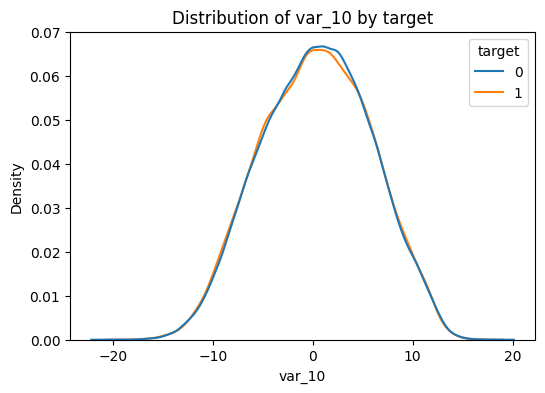

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


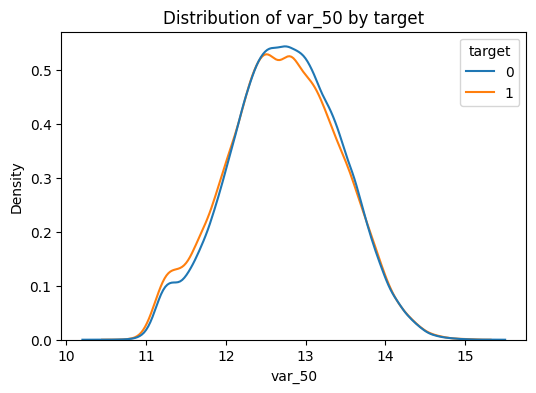

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


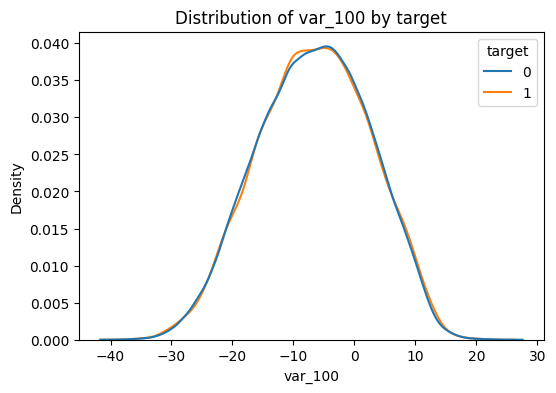


Number of duplicated feature rows in train: 0
Number of duplicated feature rows in test: 0


In [7]:
# ------------------------------------------------------------
# 3. Simple feature-level inspection by target
# ------------------------------------------------------------

# Check a few features' distribution for target 0 vs 1
example_features = ["var_0", "var_10", "var_50", "var_100"]
example_features = [f for f in example_features if f in feature_cols]  # safety

for col in example_features:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=train, x=col, hue="target", common_norm=False)
    plt.title(f"Distribution of {col} by target")
    plt.show()

# Optional: check for obvious duplicates (just as a curiosity)
dup_train = train_feats.duplicated().sum()
dup_test  = test_feats.duplicated().sum()
print("\nNumber of duplicated feature rows in train:", dup_train)
print("Number of duplicated feature rows in test:", dup_test)


In [8]:
# ------------------------------------------------------------
# 4. Train/validation split (labels only used for evaluation)
# ------------------------------------------------------------

X = train_feats.values
y = train["target"].values

# Stratified split to preserve class ratio
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train size:", X_train.shape, " Valid size:", X_valid.shape)


Train size: (160000, 200)  Valid size: (40000, 200)


In [9]:
# ------------------------------------------------------------
# 5. Scaling
# ------------------------------------------------------------

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_full_scaled  = scaler.fit_transform(X)      # for final training on all train data
X_test_scaled  = scaler.transform(test_feats) # for test predictions


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [10]:
# ------------------------------------------------------------
# 6. Unsupervised model: Isolation Forest
#     - Fit only on X_train_scaled (no y)
#     - Use anomaly scores as transaction propensity
# ------------------------------------------------------------

iso = IsolationForest(
    n_estimators=300,
    max_samples="auto",
    contamination="auto",  # let model estimate outlier proportion
    random_state=RANDOM_STATE,
    n_jobs=-1
)

iso.fit(X_train_scaled)  # unsupervised fit

# IsolationForest gives higher scores for more "normal" points.
# We want higher values for more "anomalous" (target=1).
# We'll invert the decision_function and then scale to [0, 1].
train_scores_raw = -iso.decision_function(X_train_scaled)  # higher = more anomalous
valid_scores_raw = -iso.decision_function(X_valid_scaled)

print("Train scores range:", train_scores_raw.min(), train_scores_raw.max())
print("Valid scores range:", valid_scores_raw.min(), valid_scores_raw.max())

# Min-max scaling to [0, 1] to interpret as probabilities-ish
def min_max_scale(arr):
    a_min, a_max = arr.min(), arr.max()
    if a_max == a_min:
        return np.zeros_like(arr)
    return (arr - a_min) / (a_max - a_min)

train_scores = min_max_scale(train_scores_raw)
valid_scores = min_max_scale(valid_scores_raw)


Train scores range: -0.07530921014395414 0.005305587734950379
Valid scores range: -0.07313251028536688 0.0057727494710958505


Validation ROC-AUC (IsolationForest, unsupervised): 0.6655052627357929


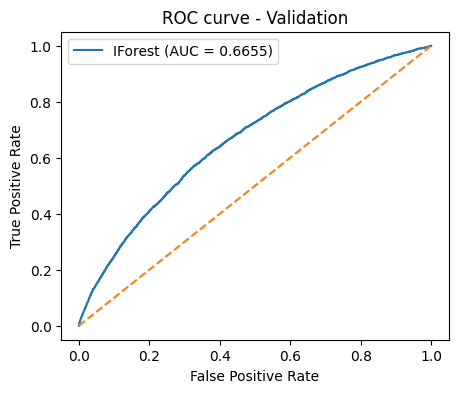

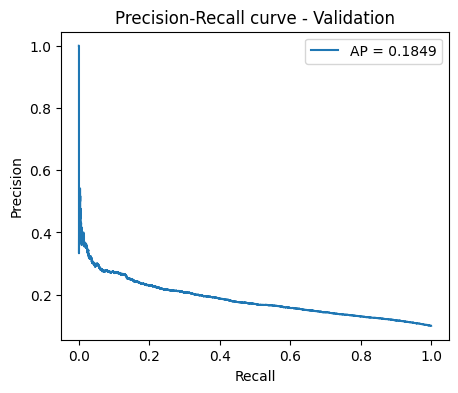

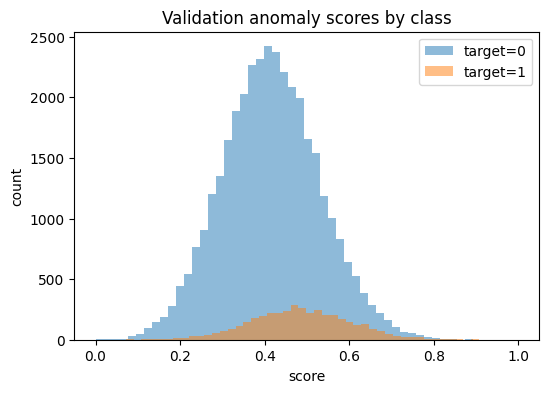

Best F1 on validation: 0.2558516801853998
Best threshold: 0.51


In [11]:
# ------------------------------------------------------------
# 7. Model analysis on validation set
# ------------------------------------------------------------

# ROC-AUC
roc_auc = roc_auc_score(y_valid, valid_scores)
print("Validation ROC-AUC (IsolationForest, unsupervised):", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_valid, valid_scores)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"IForest (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Validation")
plt.legend()
plt.show()

# Precision-Recall curve (more informative for imbalance)
prec, rec, thresholds_pr = precision_recall_curve(y_valid, valid_scores)
ap = average_precision_score(y_valid, valid_scores)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve - Validation")
plt.legend()
plt.show()

# Inspect score distributions by class
plt.figure(figsize=(6,4))
plt.hist(valid_scores[y_valid==0], bins=50, alpha=0.5, label="target=0")
plt.hist(valid_scores[y_valid==1], bins=50, alpha=0.5, label="target=1")
plt.title("Validation anomaly scores by class")
plt.xlabel("score")
plt.ylabel("count")
plt.legend()
plt.show()

# If you want a threshold for binary labels (just for inspection)
# Choose threshold that maximizes F1 on the validation set
from sklearn.metrics import f1_score

best_f1 = 0
best_thr = 0.5
for thr in np.linspace(0, 1, 101):
    y_pred_bin = (valid_scores >= thr).astype(int)
    f1 = f1_score(y_valid, y_pred_bin)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print("Best F1 on validation:", best_f1)
print("Best threshold:", best_thr)


In [12]:
# ------------------------------------------------------------
# 8. Refit IsolationForest on full training data
#     and generate predictions for test
# ------------------------------------------------------------

iso_full = IsolationForest(
    n_estimators=300,
    max_samples="auto",
    contamination="auto",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

iso_full.fit(X_full_scaled)

test_scores_raw = -iso_full.decision_function(X_test_scaled)
test_scores = min_max_scale(test_scores_raw)

print("Test scores stats:", test_scores.min(), test_scores.max(), test_scores.mean())


Test scores stats: 0.0 1.0 0.44819671122474053


In [13]:
# ------------------------------------------------------------
# 9. Build submission
# ------------------------------------------------------------

submission = pd.DataFrame({
    "ID_code": test["ID_code"],
    "target": test_scores  # use soft scores as probabilities
})

submission.head()


,ID_code,target
0,test_0,0.382655
1,test_1,0.587055
2,test_2,0.637592
3,test_3,0.512947
4,test_4,0.332973
